In [ ]:
!apt-get install git
!pip install Pillow
!pip install matplotlib
!pip install gdown

Reading package lists... Done
^C


## Clonación del Conjunto de Datos desde GitHub

El siguiente fragmento de código clona solo la carpeta `dataset` del repositorio de GitHub especificado. Esto se logra utilizando `sparseCheckout` para descargar únicamente la carpeta necesaria, lo cual es útil para evitar la descarga de archivos innecesarios del repositorio y necesario debido a la naturaleza de los datos.

Al ser un dataset considerablemente grande, otras alternativas resultaron problematicas o inviables, asi que se optó por un enfoque de traer el `dataset` de github


In [ ]:
REPO="https://github.com/CamiloVelezP/DetecionDeMascarillas"
BRANCH="main"
FOLDER="dataset"
!git init temp_repo
%cd temp_repo
!git remote add origin $REPO
!git config core.sparseCheckout true
!echo $FOLDER/ > .git/info/sparse-checkout
!git pull origin $BRANCH
%cd ..
!mv temp_repo/$FOLDER .
!rm -rf temp_repo

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/temp_repo/.git/
/content/temp_repo
remote: Enumerating objects: 8845, done.
remote: Total 8845 (delta 0), reused 0 (delta 0), pack-reused 8845
Receiving objects: 100% (8845/8845), 216.38 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (4/4), done.
From https://github.com/CamiloVelezP/DetecionDeMascarillas
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
Updating files: 100% (8982/8982), done.
/content


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

Analisis previo de la data a trabajar gracias a la descarga e importación de archivos automatica por medio del repositorio github

In [ ]:
with_mask_files = os.listdir('/content/dataset/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['1287.png', '2470.png', '2398.png', '308.png', '98.png']
['2835.png', '1971.png', '785.png', '1185.png', '2923.png']


In [ ]:
without_mask_files = os.listdir('/content/dataset/without_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['1287.png', '2470.png', '2398.png', '308.png', '98.png']
['2835.png', '1971.png', '785.png', '1185.png', '2923.png']


In [ ]:
mask_weared_incorrect_files = os.listdir('/content/dataset/mask_weared_incorrect')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['1287.png', '2470.png', '2398.png', '308.png', '98.png']
['2835.png', '1971.png', '785.png', '1185.png', '2923.png']


In [ ]:
print('Numero de imagenes con mascarilla puesta:', len(with_mask_files))
print('Numero de imagenes sin mascarilla:', len(without_mask_files))
print('Numero de imagenes con mascarilla mal puesta:', len(mask_weared_incorrect_files))

Numero de imagenes con mascarilla puesta: 2994
Numero de imagenes sin mascarilla: 2994
Numero de imagenes con mascarilla mal puesta: 2994


## Preparación de Etiquetas para las Imágenes

Creación de las etiquetas para las imágenes según su categoría:
- `with_mask_labels`: Lista de etiquetas para imágenes donde las personas llevan una máscara correctamente (etiqueta `1`).
- `without_mask_labels`: Lista de etiquetas para imágenes donde las personas no llevan una máscara (etiqueta `0`).
- `mask_weared_incorrect_labels`: Lista de etiquetas para imágenes donde las personas llevan una máscara incorrectamente (etiqueta `2`).


In [ ]:
with_mask_labels = [1]*2994

without_mask_labels = [0]*2994

mask_weared_incorrect_labels = [2]*2994

labels = without_mask_labels + with_mask_labels + mask_weared_incorrect_labels

## Carga y Preprocesamiento de Imágenes

Se realiza la carga y preprocesa las imágenes de cada categoría (`with_mask`, `without_mask`, `mask_weared_incorrect`). Las imágenes se redimensionan a 128x128 píxeles, se convierten a formato RGB y se almacenan en un array de NumPy.


In [ ]:
data = []

without_mask_path = '/content/dataset/without_mask/'
for img_file in without_mask_files:
  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

with_mask_path = '/content/dataset/with_mask/'
for img_file in with_mask_files:
  image = Image.open(with_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

mask_weared_incorrect_path = '/content/dataset/mask_weared_incorrect/'
for img_file in mask_weared_incorrect_files:
  image = Image.open(mask_weared_incorrect_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

## Conversión y División de Datos, y Escalado

Ahora se convierten las imágenes y las etiquetas en arrays de NumPy, divide los datos en conjuntos de entrenamiento y prueba, y escala los valores de las imágenes.


1. **Conversión a Arrays de NumPy:**
   - `X = np.array(data)`: Convierte la lista de imágenes `data` en un array de NumPy.
   - `Y = np.array(labels)`: Convierte la lista de etiquetas `labels` en un array de NumPy.

2. **División de Datos en Entrenamiento y Prueba:**
   - `X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)`: Divide los datos en conjuntos de entrenamiento y prueba. El 30% de los datos se usa para pruebas (`test_size=0.3`). `random_state=2` asegura que la división sea reproducible.

3. **Escalado de Datos:**
   - `X_train_scaled = X_train/255`: Escala los valores de las imágenes de entrenamiento para que estén en el rango [0, 1] en lugar de [0, 255].
   - `X_test_scaled = X_test/255`: Escala los valores de las imágenes de prueba de manera similar.


In [ ]:
# Convertir las listas de datos y etiquetas en arrays de NumPy
X = np.array(data)
Y = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

# Escalar los valores de las imágenes a un rango de [0, 1]
X_train_scaled = X_train/255
X_test_scaled = X_test/255

## Visualización de la Distribución de Clases en el Conjunto de Entrenamiento

Se visualiza la distribución de las diferentes clases (`with mask`, `weared incorrect`, `without mask`) en el conjunto de entrenamiento.


1    2137
2    2094
0    2056
Name: count, dtype: int64


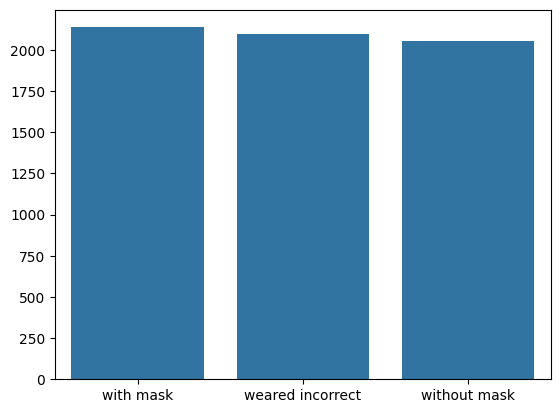

In [ ]:
dd = pd.Series(Y_train).value_counts()
print(dd)
sns.barplot(x=np.array(['with mask', 'weared incorrect', 'without mask']), y=dd.values)
plt.show()

## Definición de la Arquitectura del Modelo CNN

El siguiente paso es definir una red neuronal convolucional (CNN) con capas convolucionales, de pooling, y completamente conectadas para clasificar imágenes en las tres categorías anteriormente mencionadas: `with_mask`, `without_mask`, y `mask_weared_incorrect`. La arquitectura incluye capas convolucionales para la extracción de características, capas de max pooling para la reducción de dimensionalidad, y capas totalmente conectadas con dropout para la clasificación final utilizando una función de activación `softmax`.


In [ ]:
num_of_classes = 3  # (with_mask, without_mask, mask_weared_incorrect)
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_of_classes, activation='softmax'))

## Configuración de Callbacks

Aparte, por utilidad se configura dos callbacks importantes para el entrenamiento del modelo: reducción de la tasa de aprendizaje y "parada temprana". `ReduceLROnPlateau` ajusta la tasa de aprendizaje cuando la precisión en el conjunto de validación deja de mejorar, lo que ayuda a que el modelo converja más eficazmente. `EarlyStopping` detiene el entrenamiento si la precisión en el conjunto de validación no mejora después de 5 epochs, previniendo el sobreajuste.


In [ ]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_acc",
    factor = 0.5,
    patience = 3,
    verbose = 0,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

## Compilación del Modelo

Compilación del modelo CNN usando el optimizador Adam, la función de pérdida `sparse_categorical_crossentropy`, y la métrica de precisión (`acc`). El optimizador Adam ajusta los pesos del modelo de manera eficiente, mientras que `sparse_categorical_crossentropy` es adecuada para problemas de clasificación multiclase con etiquetas enteras.


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

## Entrenamiento del Modelo

El paso a seguir vendria a ser el entrenamiento del modelo CNN utilizando el conjunto de datos de entrenamiento escalado. Se utiliza una validación del 30% de los datos de entrenamiento (`validation_split=0.3`). El modelo se entrena durante un máximo de 20 epochs, con callbacks de reducción de la tasa de aprendizaje y parada temprana para optimizar el proceso de entrenamiento y prevenir el sobreajuste.

### Resumen del Entrenamiento
- **Época 1:** Precisión de entrenamiento: 68.95%, Precisión de validación: 87.71%
- **Época 10:** Precisión de entrenamiento: 97.55%, Precisión de validación: 96.29%
- **Época 20:** Precisión de entrenamiento: 99.32%, Precisión de validación: 97.99%

Esta celda no necesita ser ejecutada nuevamente ya que el entrenamiento tomó 40 minutos. Se deja aquí para referencia histórica.


In [ ]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.3, epochs=20, callbacks = [learning_rate_reduction, early_stopping])


Epoch 1/20
138/138 [==============================] - 127s 907ms/step - loss: 0.7446 - acc: 0.6895 - val_loss: 0.3866 - val_acc: 0.8771 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 121s 881ms/step - loss: 0.3932 - acc: 0.8682 - val_loss: 0.3844 - val_acc: 0.8802 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 112s 816ms/step - loss: 0.2886 - acc: 0.9059 - val_loss: 0.1683 - val_acc: 0.9391 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 120s 873ms/step - loss: 0.2265 - acc: 0.9252 - val_loss: 0.1677 - val_acc: 0.9380 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 120s 870ms/step - loss: 0.1931 - acc: 0.9373 - val_loss: 0.1433 - val_acc: 0.9491 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 122s 885ms/step - loss: 0.1416 - acc: 0.9552 - val_loss: 0.1262 - val_acc: 0.9571 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 120s 874ms/step - loss: 0.1186 - acc: 0.9625 - val_l

Por ultimo se realiza el guardado del modelo entrenado, esto como se menciona antes ya se realizo, pero se deja evidenciado como fue el proceso

In [ ]:
model.save('modelo_final')


## Descarga y Descompresión del Modelo Preentrenado

A continuación se descargará el modelo ya entrenado desde Google Drive utilizando `gdown` y se descomprimirá. Esto con el fin de realizar pequeñas pruebas de funcionalidad al igual que revisar metricas


In [ ]:
file_id = '1yZ72WmBQl5FBS55hv2apaA0nbJGU151E'
destination = 'modelo.zip'

import gdown

# Descargar el archivo usando gdown
gdown.download(id=file_id, output=destination)

# Descomprimir el archivo
!unzip {destination} -d /content/

Downloading...
From (original): https://drive.google.com/uc?id=1yZ72WmBQl5FBS55hv2apaA0nbJGU151E
From (redirected): https://drive.google.com/uc?id=1yZ72WmBQl5FBS55hv2apaA0nbJGU151E&confirm=t&uuid=1bc894d7-9a2c-4a20-8efb-3fe0cecbf1a0
To: /content/modelo.zip
100%|██████████| 73.7M/73.7M [00:00<00:00, 83.9MB/s]


Archive:  modelo.zip
   creating: /content/mi_modelo_final/
   creating: /content/mi_modelo_final/assets/
  inflating: /content/mi_modelo_final/correct (1).png  
  inflating: /content/mi_modelo_final/correct (2).png  
  inflating: /content/mi_modelo_final/correct (3).png  
 extracting: /content/mi_modelo_final/fingerprint.pb  
  inflating: /content/mi_modelo_final/incorrect (1).png  
  inflating: /content/mi_modelo_final/incorrect (2).png  
  inflating: /content/mi_modelo_final/incorrect (3).png  
  inflating: /content/mi_modelo_final/keras_metadata.pb  
  inflating: /content/mi_modelo_final/others (1).jpg  
  inflating: /content/mi_modelo_final/others (2).jpg  
  inflating: /content/mi_modelo_final/others (3).jpg  
  inflating: /content/mi_modelo_final/others (4).jpg  
  inflating: /content/mi_modelo_final/others (5).jpg  
  inflating: /content/mi_modelo_final/others (6).jpg  
  inflating: /content/mi_modelo_final/saved_model.pb  
   creating: /content/mi_modelo_final/variables/
  inf

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
modelNew = load_model('/content/mi_modelo_final')


## Evaluación del Modelo con Matriz de Confusión e Informe de Clasificación

Evaluación del modelo preentrenado utilizando la matriz de confusión y el informe de clasificación en el conjunto de datos de prueba al igual que medición del rendimiento del modelo en términos de precisión, recall y f1-score para cada clase.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Generar predicciones en el conjunto de prueba
Y_pred_prob = modelNew.predict(X_test_scaled)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Definir los nombres de las clases
label_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']

# Imprimir la matriz de confusión para el conjunto de prueba
test_confusion_mat = confusion_matrix(Y_test, Y_pred)
print("Test Confusion Matrix:")
print(test_confusion_mat)

# Imprimir el informe de clasificación para el conjunto de prueba
test_classification_rep = classification_report(Y_test, Y_pred, target_names=label_names)
print("Test Classification Report:")
print(test_classification_rep)

85/85 [==============================] - 20s 233ms/step
Test Confusion Matrix:
[[926   9   3]
 [  3 845   9]
 [  0   4 896]]
Test Classification Report:
                       precision    recall  f1-score   support

            with_mask       1.00      0.99      0.99       938
         without_mask       0.98      0.99      0.99       857
mask_weared_incorrect       0.99      1.00      0.99       900

             accuracy                           0.99      2695
            macro avg       0.99      0.99      0.99      2695
         weighted avg       0.99      0.99      0.99      2695



In [ ]:
loss, accuracy = modelNew.evaluate(X_test_scaled, Y_test)
print('Precision de prueba =', accuracy)

85/85 [==============================] - 19s 227ms/step - loss: 0.0424 - acc: 0.9896
Precision de prueba = 0.9896103739738464


## Gráficas

Graficas de los valores de la pérdida y la precisión durante el entrenamiento y la validación del modelo a lo largo del paso de los epochs.
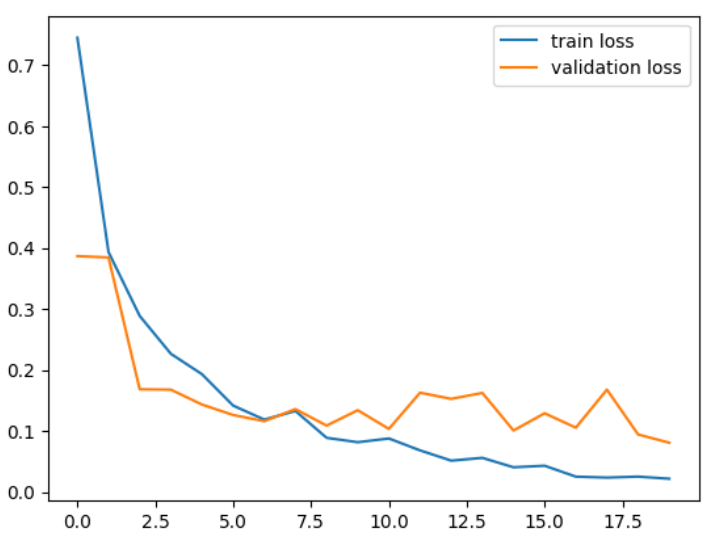


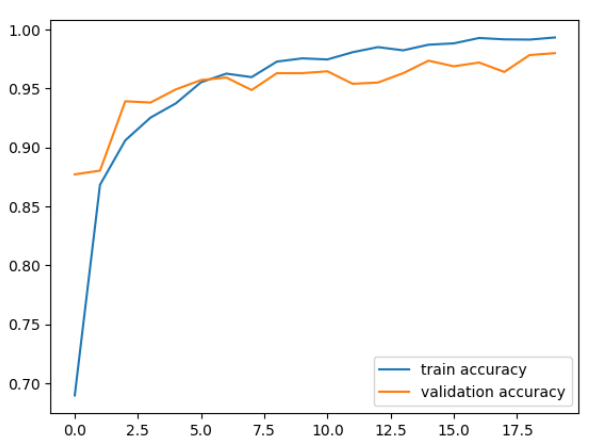

## Prueba del Modelo con una Imagen Individual

El siguiente código realiza una prueba del modelo preentrenado utilizando una imagen individual. Se preprocesa la imagen, se genera una predicción y se muestra el resultado junto con la imagen original.


1/1 [==============================] - 0s 49ms/step
[[3.77491187e-06 9.99891758e-01 1.04423714e-04]]
1
La persona en la imagen está usando una mascarilla


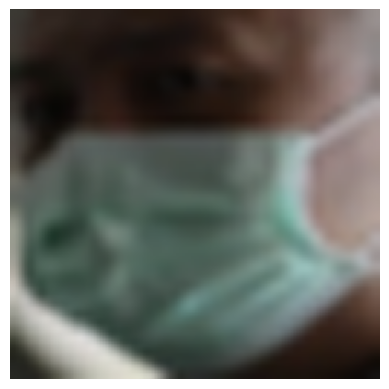

In [ ]:
input_image_path = '/content/dataset/with_mask/305.png'

# Cargar y preprocesar la imagen
image = Image.open(input_image_path)
image_test = image.resize((128,128))
image_test = image_test.convert('RGB')
image_test = np.array(image_test)
image_scaled = image_test/255
image_reshaped = np.reshape(image_scaled, [1,128,128,3])

# Generar la predicción
input_prediction = modelNew.predict(image_reshaped)
print(input_prediction)
input_pred_label = np.argmax(input_prediction)
print(input_pred_label)

# Interpretar la predicción
if input_pred_label == 0:
  print('La persona en la imagen no está usando una mascarilla')
elif input_pred_label == 1:
  print('La persona en la imagen está usando una mascarilla')
else:
  print('La persona en la imagen está usando una mascarilla incorrectamente')

# Cargar y mostrar la imagen
img = mpimg.imread(input_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

En el notebook de `test` se puede apreciar mas pruebas respecto a la funcionalidad del modelo en distintos casos